# Real World Data Science Interview Assignment

This assignment shows my work in roughly the order that I examined the data and built the model. I left it as such so that those analyzing the work could see my thought processes as I went through the assignment.

## Executive  Summary

A simple model flagging all transactions that occurred in one second and those that had a repeated device ID with price above 29 dollars appears to capture most of the potential value. More investigation needs to be done to determine if other models would be able to find more signal in the data to flag more transactions as fraud.

## Read in data

On read, several columns will be converted to a different type. The two time columns will be converted to datetime. The source, browser, and sex columns are converted to categorical as they have very low cardinality. Some memory is saved by using an 8-bit integer for the class column. The first column in the CSV is unnamed containing unique integers and is not read.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    rc={
        "figure.dpi": 144,
        "ytick.labelsize": 7,
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "axes.titlesize": 9,
    }
)

dtype = {
    "source": "category",
    "browser": "category",
    "sex": "category",
    "class": "uint8",
}
df = pd.read_csv(
    # "./data/fraud.csv",
    "../../data/fraud.csv",
    usecols=range(1, 12),
    dtype=dtype,
    parse_dates=["signup_time", "purchase_time"],
)
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


### Get metadata

* 120k rows, 11 columns

In [4]:
df.shape

(120000, 11)

### Output data types

In [5]:
df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                  category
browser                 category
sex                     category
age                        int64
ip_address               float64
class                      uint8
dtype: object

### Check for missing values

No missing values

In [6]:
df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

### Examine uniqueness

Some repeating device ids and ip_addresses, but mostly unique.

In [7]:
df.nunique()

user_id           120000
signup_time       120000
purchase_time     119729
purchase_value       120
device_id         110599
source                 3
browser                5
sex                    2
age                   57
ip_address        114135
class                  2
dtype: int64

##   Read in IP Address mapping data

The upper_bound_ip_address is read in as an integer, but needs to be converted to a float for the `merge_asof` pandas function to work with it. The country column is converted to categorical.

In [8]:
dtype = {"upper_bound_ip_address": "float64", "country": "category"}
df_ip = pd.read_csv("../../data/IpAddress_to_Country.csv", dtype=dtype)
df_ip = df_ip.sort_values("lower_bound_ip_address")
df_ip.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471.0,Australia
1,16777472.0,16777727.0,China
2,16777728.0,16778239.0,China
3,16778240.0,16779263.0,Australia
4,16779264.0,16781311.0,China


### Get metadata

In [9]:
df_ip.shape

(138846, 3)

In [10]:
df_ip.dtypes

lower_bound_ip_address     float64
upper_bound_ip_address     float64
country                   category
dtype: object

All IP Addresses in lookup table are unique.

In [11]:
df_ip.nunique()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                      235
dtype: int64

In [12]:
df_ip.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

### Check that IP Addresses are sorted and do not overlap

We want to ensure each IPAddress range is mapped to exactly one country. The addresses need to be sorted as well for `merge_asof` to work. We stack them in one Series below.

In [13]:
s = df_ip.iloc[:, :2].stack().droplevel(1)
s.head()


0    16777216.0
0    16777471.0
1    16777472.0
1    16777727.0
2    16777728.0
dtype: float64

Verify they are sorted and do not overlap.

In [14]:
s.is_monotonic_increasing

True

## Add country

The `merge_asof` pandas function allows you to join two DataFrames on keys that don't match. The DataFrames must be sorted by their `left_on` and `right_on` columns. Below, the left (fraud) DataFrame will match with the last row of the right (ip addresses) DataFrame where the lower_bound_ip_address is less than the ip_address. First we sort the data and then perform the merge.

In [15]:
df = df.sort_values("ip_address")
df_all = pd.merge_asof(
    df, df_ip, left_on="ip_address", right_on="lower_bound_ip_address"
)
df_all.tail(2)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
119998,172984,2015-08-15 15:40:46,2015-10-30 09:47:39,9,TSDCMHPWAUZAR,Ads,IE,F,35,4.294822e+09,0,3.758096e+09,3.758096e+09,Australia
119999,168001,2015-03-03 11:27:19,2015-05-05 10:32:46,39,JLVKRXCKCWNLW,Ads,FireFox,F,41,4.294850e+09,0,3.758096e+09,3.758096e+09,Australia


While this works for most of the rows, the ip address is not checked for an upper bound. As you can see above, there are rows where the ip_address is not in the interval. Below, we make the country value missing in the rows where the ip_address is not between the bounds. Missing values for country are filled with the string 'Unknown'. The data is then sorted by signup time.

In [16]:
filt = df_all["ip_address"].between(
    df_all["lower_bound_ip_address"], df_all["upper_bound_ip_address"]
)


df_all["country"] = df_all["country"].where(filt)


df_all["country"] = (
    df_all["country"]
    .cat.remove_unused_categories()
    .cat.add_categories("Unknown")
    .fillna("Unknown")
)


df_all = df_all.drop(columns=["lower_bound_ip_address", "upper_bound_ip_address"])


df_all = df_all.sort_values("signup_time", ignore_index=True)


df_all.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of


Find the number of missing values now. About 17k rows have IP addresses that are not found in our table.

In [17]:
(df_all["country"] == "Unknown").sum()

17418

## Creating a hold-out test dataset

Before going any further, we will split our dataset into training and testing sets. We will not look at the test set until the very end of our analysis, in which we will use to get a final evaluation of our model. Since transactions are coming in over time, we will not randomly split the data, and instead choose to hold out the last 20%. The data is currently sorted by signup_time so selecting the tail of the DataFrame will work.

Splitting the data like this provides a much more realistic assessment of our analysis/model as it would happen in the real world.

In [18]:
hold_out = len(df_all) // 5
df_train = df_all.iloc[:-hold_out]
df_test = df_all.iloc[-hold_out:]


We verify the split happened by outputting the tail/head of the new DataFrames.

In [19]:
df_train.tail(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
95997,74448,2015-06-30 23:15:51,2015-07-29 15:38:55,29,ZNSKBVNQWQANG,Ads,IE,M,34,1.489732e+09,0,Bulgaria
95998,233722,2015-06-30 23:16:50,2015-07-06 04:36:00,34,BYHIAEGRYUFTN,Ads,Chrome,M,43,2.177280e+09,1,United States
95999,102254,2015-06-30 23:17:45,2015-10-04 21:52:34,46,AVGWGXJMCNHFY,Direct,Chrome,F,37,2.056748e+09,0,Australia


In [20]:
df_test.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
96000,193125,2015-06-30 23:18:23,2015-09-01 15:39:26,9,IFMCHPMYFWIMI,Ads,Chrome,F,34,3.611508e+09,0,United States
96001,294823,2015-06-30 23:19:04,2015-10-16 10:34:41,57,RIMPMUBEETXTZ,Ads,IE,M,33,1.934021e+08,0,United States
96002,91188,2015-06-30 23:20:13,2015-07-07 22:53:13,74,VHHMBZZYCJPDA,Ads,Chrome,M,31,5.421422e+08,0,United States


To further verify, the shape of each is outputted below.

In [21]:
df_train.shape

(96000, 12)

In [22]:
df_test.shape

(24000, 12)

Write the dataset to disk.

In [23]:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)


## Summary statistics of simple continuous and categorical columns

Summary statistics for some of the "simpler" continuous and categorical columns:

* Continuous
    * purchase_value
    * age
* Categorical
    * source
    * browser
    * sex
    * country
    * class

### purchase_value

In [24]:
df_train[["purchase_value", "age"]].describe()

,purchase_value,age
count,96000.000000,96000.000000
mean,36.858146,33.134917
std,18.354777,8.625734
min,9.000000,18.000000
25%,22.000000,27.000000
50%,34.000000,33.000000
75%,49.000000,39.000000
max,154.000000,76.000000


A Histogram, KDE, and boxplot are created to better understand the distribution of purchase value. It appears fairly uniform between 10 and 40 and then drops off quickly.

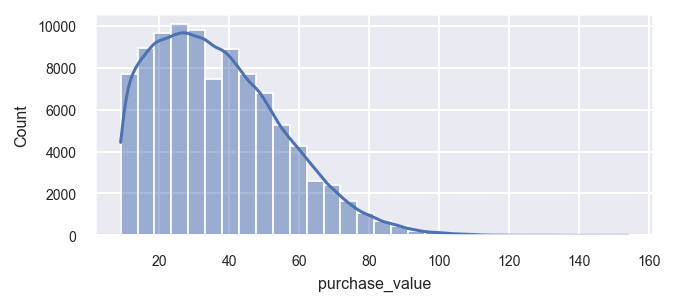

In [25]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data=df_train, x="purchase_value", kde=True, bins=30, ax=ax);


Age is more normally distributed.

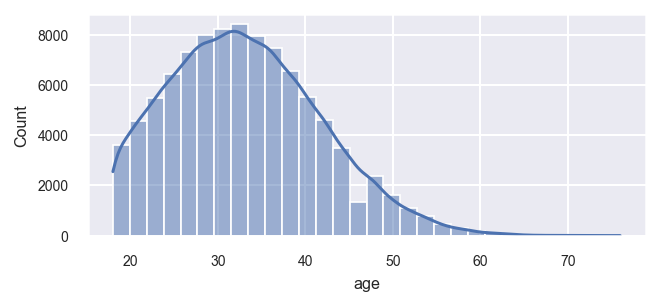

In [26]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.histplot(data=df_train, x="age", kde=True, bins=30, ax=ax);


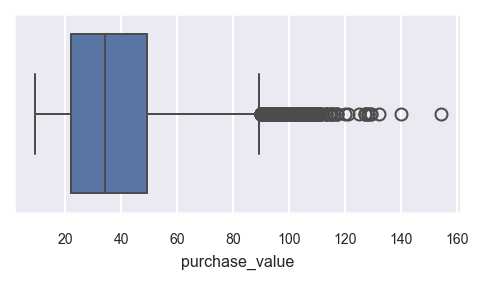

In [27]:
fig, ax = plt.subplots(figsize=(4, 1.8))
sns.boxplot(data=df_train, x="purchase_value");


### source

In [28]:
df_train["source"].value_counts(normalize=True)

source
SEO       0.403167
Ads       0.395021
Direct    0.201813
Name: proportion, dtype: float64

### browser

In [29]:
df_train["browser"].value_counts()

browser
Chrome     38981
IE         23260
FireFox    15690
Safari     15687
Opera       2382
Name: count, dtype: int64

### sex

In [30]:
df_train["sex"].value_counts()

sex
M    56087
F    39913
Name: count, dtype: int64

### country

In [31]:
s = df_train["country"].value_counts()
s.head()


country
United States     36977
Unknown           13882
China              7595
Japan              4622
United Kingdom     2869
Name: count, dtype: int64

Find percent of countries that appear less than 50 times.

In [32]:
round((s < 50).mean(), 3) * 100

61.0

## class

Get frequency

In [33]:
df_train["class"].value_counts()

class
0    85845
1    10155
Name: count, dtype: int64

10.6% are fraud

In [34]:
df_train["class"].value_counts(normalize=True).round(3) * 100

class
0    89.4
1    10.6
Name: proportion, dtype: float64

## Univariate exploration

Explore relationship to target with these simple columns. Let's see if we discover any values that are sufficiently different than the 10.6% fraud.

There is a small signal here with source. Direct is 1% more fraud.

In [35]:
df_train.groupby("source").agg(count=("class", "size"), perc_fraud=("class", "mean"))

C:\Users\eorlo\AppData\Local\Temp\ipykernel_4460\457251746.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby("source").agg(count=("class", "size"), perc_fraud=("class", "mean"))


,count,perc_fraud
source,,
Ads,37922,0.103845
Direct,19374,0.118613
SEO,38704,0.101256


Browser does not appear to have much signal. IE has slightly lower fraud.

In [36]:
df_train.groupby("browser").agg(count=("class", "size"), perc_fraud=("class", "mean"))

C:\Users\eorlo\AppData\Local\Temp\ipykernel_4460\2162988225.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby("browser").agg(count=("class", "size"), perc_fraud=("class", "mean"))


,count,perc_fraud
browser,,
Chrome,38981,0.112516
FireFox,15690,0.106883
IE,23260,0.096303
Opera,2382,0.102015
Safari,15687,0.102569


Slightly more fraud by males.

In [37]:
df_train.groupby("sex").agg(count=("class", "size"), perc_fraud=("class", "mean"))

C:\Users\eorlo\AppData\Local\Temp\ipykernel_4460\1587004642.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby("sex").agg(count=("class", "size"), perc_fraud=("class", "mean"))


,count,perc_fraud
sex,,
F,39913,0.102799
M,56087,0.107904


Look at the highest and lowest fraud by countries with more than 50 transactions. There appears to be much more signal here (though smaller counts).

In [38]:
df_country = df_train.groupby("country").agg(
    count=("class", "size"), perc_fraud=("class", "mean")
)
df_country.query("count > 50").nlargest(15, "perc_fraud")


C:\Users\eorlo\AppData\Local\Temp\ipykernel_4460\1760579556.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country = df_train.groupby("country").agg(


,count,perc_fraud
country,,
Peru,74,0.351351
Ecuador,68,0.323529
Tunisia,78,0.294872
Kuwait,60,0.266667
Ireland,169,0.266272
Lithuania,62,0.258065
Saudi Arabia,181,0.243094
New Zealand,186,0.225806
Denmark,309,0.184466


In [39]:
df_country.query("count > 50").nsmallest(15, "perc_fraud")

,count,perc_fraud
country,,
Slovenia,57,0.000000
Bulgaria,102,0.009804
Morocco,106,0.028302
Pakistan,117,0.034188
Israel,169,0.035503
Kazakhstan,52,0.038462
Portugal,140,0.042857
Slovakia (SLOVAK Republic),57,0.052632
European Union,160,0.056250


Looking at the top 15 larges countries, most are around the average.

In [40]:
df_country.nlargest(15, "count")

,count,perc_fraud
country,,
United States,36977,0.108797
Unknown,13882,0.096600
China,7595,0.094799
Japan,4622,0.109693
United Kingdom,2869,0.117114
Korea Republic of,2644,0.103253
Germany,2311,0.082215
France,1962,0.110601
Canada,1911,0.130822


Here, the Pearson correlation coefficient is calculated on all of the numeric columns. There appears to be no relationship.

In [41]:
df_train.corr()["class"]

ValueError: could not convert string to float: 'BBPACGBUVJUXF'

We can still bin the numeric columns to see if there is any relationship. The highest priced bin has by far the lowest fraud while the 85-100 have significantly more.

In [ ]:
g = pd.cut(df_train['purchase_value'], bins=list(range(5, 105, 10)) + [200])
df_temp = df_train.groupby(g).agg(count=('class', 'size'), perc_fraud=('class', 'mean'))
df_temp['perc_fraud'] = df_temp['perc_fraud'].round(3) * 100
df_temp

Again, not much signal with age.

In [ ]:
g = pd.cut(df_train['age'], bins=list(range(15, 70, 5)) + [100])
df_temp = df_train.groupby(g).agg(count=('class', 'size'), perc_fraud=('class', 'mean'))
df_temp['perc_fraud'] = df_temp['perc_fraud'].round(3) * 100
df_temp

We can even check the user_id to see if there is signal there. The results are what we would expect from randomness.

In [ ]:
df_train.groupby(pd.qcut(df_train['user_id'], 100))['class'].mean().nlargest()

## Multivariate exploration

We can look at different combinations of the categorical variables to see if there is any signal. We write a function to calculate the percent fraud for different groupings.

In [ ]:
def fraud_group(df, cols, min_count=50, n=10):
    df = df.groupby(cols) \
           .agg(count=('class', 'size'),
                perc_fraud=('class', 'mean'),
                avg_price=('purchase_value', 'mean'))
    df['perc_fraud'] = df['perc_fraud'].round(3) * 100
    return df.query('count > @min_count').nlargest(n, 'perc_fraud')

Grouping by browser, source, and sex reveals only a few combinations with small signal.

In [ ]:
fraud_group(df_train, ['browser', 'source', 'sex'])

Adding in country, there are some combinations that have much higher fraud, though the overall counts are low.

In [ ]:
fraud_group(df_train, ['country', 'browser', 'source', 'sex'])

We can use the bins for age and purchase value as well.

In [ ]:
g = pd.cut(df_train['age'], bins=list(range(15, 70, 5)) + [100])
fraud_group(df_train, ['browser', 'source', g])

## Explore signup and purchase time

Date columns require a different approach for analysis.

### Seconds until purchase

We begin by finding the seconds until purchase.

In [ ]:
secs_to_purchase = (df_train['purchase_time'] - df_train['signup_time']).dt.total_seconds()
secs_to_purchase.head(3)

Interestingly, the first few rows all had purchases after one second and all were fraudulent. Let's select all purchases that happened in one second.

In [ ]:
filt = secs_to_purchase == 1
df_train.loc[filt, 'class'].agg(['mean', 'size'])

Remarkably, every single transaction that took place in 1 second was marked as fraud.

### Separating out 1 second transactions

Since we found a one to one mapping between a feature of our dataset and fraud, let's filter out this data into its own DataFrame.

In [ ]:
df_one_second = df_train[filt].reset_index(drop=True)
df_remaining = df_train[~filt].reset_index(drop=True)

### Metadata for new datasets

In [ ]:
df_one_second.shape

In [ ]:
df_remaining.shape

Percent of "Unknown" countries shows they are similar.

In [ ]:
(df_one_second['country'] == "Unknown").mean() * 100

In [ ]:
(df_remaining['country'] == "Unknown").mean() * 100

Number of unique values by column.

In [ ]:
df_one_second.nunique()

In [ ]:
df_remaining.nunique()

### Repeating IP Addresses

From above, the one second purchase data has lots of repeating IP addresses.

In [ ]:
df_one_second['ip_address'].value_counts().head()

In fact, all of the repeating IP addresses are in the one second data. None are in the remaining.

In [ ]:
df_remaining['ip_address'].is_unique

### Distribution of transactions over time

Let's look at the number of transaction per month.

In [ ]:
df_one_second.resample('M', on='signup_time').size()

All of the one second transactions took place in January with about the same number per day.

In [ ]:
df_one_second.resample('D', on='signup_time').size()

All of the other transactions appear to be fairly evenly distributed across the months.

In [ ]:
df_remaining.resample('M', on='signup_time', kind='period').size()

## New baseline

Now that we've separated out the one second transaction, we'll recalculate the percent fraudulent.

In [ ]:
df_remaining['class'].mean()

We'll focus on building a model on the remaining dataset and look for groups that have significantly more fraud than **4.6%**.

### Group again

Let's look at some of the same groups from above with our new filtered data.

In [ ]:
fraud_group(df_remaining, 'sex')

In [ ]:
fraud_group(df_remaining, 'source')

In [ ]:
fraud_group(df_remaining, 'browser')

In [ ]:
fraud_group(df_remaining, 'country')

In [ ]:
g = pd.cut(df_remaining['purchase_value'], bins=list(range(5, 105, 5)) + [200])
fraud_group(df_remaining, g)

In [ ]:
g = pd.cut(df_remaining['purchase_value'], bins=list(range(5, 105, 5)) + [200])
fraud_group(df_remaining, g)

In [ ]:
g = pd.cut(df_remaining['age'], bins=list(range(15, 70, 5)) + [100])
fraud_group(df_remaining, g)

In [ ]:
fraud_group(df_remaining, ['country', 'browser', 'source', 'sex'])

### More date features

New features can be generated for each of the date columns such as:

* day name
* month
* hour
* minute

We begin with looking at the day name of the signup time.

In [ ]:
g = df_remaining['signup_time'].dt.day_name()
g.head()

Calculating fraud by day name doesn't appear to provide much signal.

In [ ]:
fraud_group(df_remaining, g)

Similarly, no signal for purchase time day name.

In [ ]:
fraud_group(df_remaining, df_remaining['purchase_time'].dt.day_name())

The hour does not seem to matter either.

In [ ]:
fraud_group(df_remaining, df_remaining['purchase_time'].dt.hour)

In [ ]:
fraud_group(df_remaining, df_remaining['purchase_time'].dt.minute)

### Device ID

We now turn our attention to device_id. From the number of unique values, we know there are some that repeat. Let's look at those first.

In [ ]:
df_remaining['device_id'].value_counts()[lambda x: x > 1].head()

The repeated device IDs are assigned to a variable. The `df_train` DataFrame is used to check for duplicates in the entire dataset.

In [ ]:
repeat_device_id = df_train['device_id'].value_counts()[lambda x: x > 1].index
repeat_device_id[:10]

All transactions for these repeats are placed in their own DataFrame.

In [ ]:
df_repeat_device = df_remaining.query('device_id in @repeat_device_id') \
                               .sort_values('device_id', ignore_index=True)
df_repeat_device.head(4)

In [ ]:
df_repeat_device.shape

### Higher fraud for repeated device ID

Overall, there is significantly more fraud for these transactions. An average of **21%** are fraud.

In [ ]:
df_repeat_device['class'].mean()

A feature is created to indicate the number of the transaction for the given device ID.

In [ ]:
df_repeat_device['device_ct'] = df_repeat_device.groupby('device_id').cumcount() + 1
df_repeat_device[['device_id', 'device_ct', 'class']].head(6)

This enables us to test whether the first, second transaction has more probability of fraud. Below, we see that the second transaction from the same device ID has similar fraud as the first. Only a few have more than two transactions.

In [ ]:
df_repeat_device.groupby('device_ct')['class'].agg(['size', 'mean'])

### Streaks of fraudulent transactions

In this section, we'll look to see if fraudulent transactions occur in streaks. Our data is sorted by signup time, so we'll start with it. We shift the class column values down one which has the effect of looking at whether the very previous signup transaction was fraudulent.

In [ ]:
df_remaining.groupby(df_remaining['class'].shift())['class'].mean()

No signal is found. We can look at the previous 100 transactions and group by whether there are more or less than 5 frauds as a proxy for streaks. Again, no signal is detected.

In [ ]:
g = df_remaining['class'].rolling(100).sum().shift() > 5
df_remaining.groupby(g)['class'].agg(['size', 'mean'])

Let's complete the same analysis, but sort by purchase time.

In [ ]:
df_remaining_purch = df_remaining.sort_values('purchase_time', ignore_index=True)
df_remaining_purch.head(3)

No signal present here.

In [ ]:
df_remaining_purch.groupby(df_remaining_purch['class'].shift())['class'].mean()

In [ ]:
g = df_remaining_purch['class'].rolling(100).sum().shift() > 5
df_remaining_purch.groupby(g)['class'].agg(['size', 'mean'])

## Simplest model without machine learning

I like to formulate models without machine learning that can act as a baseline. There appear to be only two significant signals thus far:

* One second until purchase
* Repeated device ID

Because the one second until purchase yielded 100% fraudulent transactions, we have already separated it out into its own DataFrame. Any future transaction that occurs in one second will be flagged. Though as a cautionary note, all of these transaction happened in January. So future one second events would have to be watched carefully.

### Expected value of flagged fraud

Repeated device IDs showed to be 22% fraudulent, much higher than the 4.6% baseline. But, we must take into account the cost of an incorrectly flagged transaction (8 dollars). Even knowing that a device ID repeats, we will be wrong 78% of the time. In order to break even, the purchase price multiplied by the probability of fraud must be greater than 8 times the probability of not fraud. We have the following equation:

$$ P * p_{f} > (1 - p_{f}) * 8$$

We solve for the minimum purchase price.

In [ ]:
INCORRECT_FRAUD_COST = 8
def calc_min_price(p):
    min_purchase_price = (1 - p) * INCORRECT_FRAUD_COST / p
    return min_purchase_price

p = df_repeat_device['class'].mean()
calc_min_price(p)

Therefore, the simplest model we can build would flag all transactions where a repeated device made a purchase of 29.5 or more. The function below summarizes the flagging of fraud and cost/savings to the company.

In [ ]:
def calc_income(df, min_price):
    df = df[['purchase_value', 'class']].copy()
    df['flag'] = 0
    df['cost'] = 0
    df['saved'] = 0
    df['revenue'] = 0
    is_flag = df['purchase_value'] >= min_price
    is_fraud = df['class'] == 1
    df.loc[is_flag, 'flag'] = 1
    false_pos = is_flag & ~is_fraud
    false_neg = ~is_flag & is_fraud
    true_pos = is_flag & is_fraud
    df.loc[false_pos, 'cost'] = -INCORRECT_FRAUD_COST
    df.loc[false_neg, 'cost'] = -df['purchase_value']
    df.loc[true_pos, 'saved'] = df['purchase_value']
    df.loc[df['class'] == 0, 'revenue'] = df['purchase_value']
    df['income'] = df['revenue'] + df['cost']
    return df

Running this function with a minimum price of 29 dollars yields the following results. The first two transactions are marked as fraud incorrectly, losing the company 8 dollars each time. The next transactions is marked correctly as fraud saving the company 32 dollars. The 18th transaction is fraud, but not flagged, costing the company 19 dollars.

In [ ]:
df_income = calc_income(df_repeat_device, 29)
df_income.head(20)

We can test our simple model by finding the total cost at all price points.

In [ ]:
s = pd.Series({i: calc_income(df_repeat_device, i)['cost'].sum() for i in range(9, 100)})
s.head(10)

The price that minimizes the cost is at 31, very close to our calculation of 29.5.

In [ ]:
s.idxmax()

We can make a plot of how the cost varies with different thresholds. A threshold of 100 is essentially no threshold (almost no frauds marked) as very few transactions are made past that price point.

In [ ]:
def plot_threshold(df, col, title):
    s = pd.Series({i: calc_income(df, i)[col].sum() for i in range(9, 100)})
    ax = s.plot(figsize=(5, 2.5))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Minimum Price Threshold')
    ax.set_title(title);

In [ ]:
plot_threshold(df_repeat_device, 'cost', 'Repeated Device Fraud Threshold')

### Unique device ID

Let's put the transactions coming from a unique device ID in their own DataFrame.

In [ ]:
df_unique_device = df_remaining.query('device_id not in @repeat_device_id')
df_unique_device.head(3)

In [ ]:
df_unique_device['device_id'].is_unique

In [ ]:
df_unique_device.shape

We know have three mutually exclusive DataFrames that contain all of the data:

* df_one_second
* df_repeat_device
* df_unique_device

Let's verify that the number of rows equals 96,000.

In [ ]:
len(df_one_second) + len(df_repeat_device) + len(df_unique_device)

Let's get the baseline fraud for this subset.

In [ ]:
df_unique_device['class'].mean()

It's down to just 3.6%. It might be difficult to find a group within here that makes it worthwhile to flag as fraud. Even when grouping by 4 variables below, the highest fraud percent is 10%.

In [ ]:
fraud_group(df_unique_device, ['country', 'source', 'browser', 'sex'])

Let's calculate the minimum price needed to flag a transaction as fraudulent.

In [ ]:
calc_min_price(df_unique_device['class'].mean())

This is greater than the maximum, so no transactions would be flagged. Let's plot the cost against the price threshold for this dataset. As expected, there is no threshold that is viable.

In [ ]:
plot_threshold(df_unique_device, 'cost', 'Unique Device Fraud Threshold')

## Formal machine learning

In this section, we'll take a more formal approach to model building by using sophisticated pre-built machine learning algorithms from the scikit-learn python library. As we did above, we will slowly build models gradually increasing complexity. We will work with the entire training dataset to show how transformations can be automated and passed through a machine learning pipeline.

In [ ]:
df_train.head(3)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Two functions are defined to create two features, both of which are booleans. The first determines whether the transaction took place in one second and the second determines if the device ID is duplicated.

In [ ]:
def is_one_second(df, return_frame=True):
    s = (df['purchase_time'] - df['signup_time']).dt.total_seconds() == 1
    if return_frame:
        return s.to_frame()
    return s

def is_dupe_device(s, return_frame=True):
    s = s.duplicated(keep=False)
    if return_frame:
        return s.to_frame()
    return s

ft_one_second = FunctionTransformer(is_one_second)
ft_dupe_device = FunctionTransformer(is_dupe_device)

A machine learning pipeline is built to transform the columns before sending them to the logistic regression model which is used for classification. The source, browser, and sex nominal categorical variables are one-hot encoded. The above functions are used to produce the other two features.

In [ ]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(), ['source', 'browser', 'sex']),
    ('one_second', ft_one_second, ['signup_time', 'purchase_time']),
    ('dev', ft_dupe_device, 'device_id'),
])
lr = LogisticRegression(max_iter=1000)
pipe = Pipeline([
    ('ct', ct),
    ('lr', lr)
])

The pipeline is fit (variables transformed and model trained) and the probabilities of fraud are returned.

In [ ]:
y_true = df_train['class']
pipe.fit(df_train, y=y_true);
probs = pipe.predict_proba(df_train)
probs[:5]

The probability of fraud is contained in the second column and assigned to the variable name `y_pred`.

In [ ]:
y_pred = probs[:, 1]
y_pred

The maximum probability of fraud was over 99%.

In [ ]:
y_pred.max()

Let's see if the model was able to find the one second transactions that were all fraudulent by filtering for all transactions with higher than 99% probability.

In [ ]:
df_train[y_pred > .99].head()

These are the same 6,021 rows found earlier.

In [ ]:
df_one_second.shape

Let's look at the probabilities of fraud for the duplicated device IDs that are not one second transactions.

In [ ]:
filt1 = is_dupe_device(df_train['device_id'], return_frame=False)
filt2 = is_one_second(df_train, return_frame=False)
filt = filt1 & ~filt2
prob_fraud_dupe_device = y_pred[filt]
prob_fraud_dupe_device[:10]

The range of probabilities is between 20% and 26%, around our calculated 21% fraud without machine learning.

In [ ]:
prob_fraud_dupe_device.min(), prob_fraud_dupe_device.max()

### Confusion matrix

Let's get a look at all of the combinations of events - true positives/negatives and false positives/negatives by creating a confusion matrix. First we use our `calc_income` function to get the final decision.

In [ ]:
min_price = calc_min_price(y_pred)
df_income = calc_income(df_train, min_price)
df_income.head()

Use scikit-learn to create confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
def create_confusion(y_true, df_income, filt=None):
    y_pred = df_income['flag']
    if filt is not None:
        y_true = y_true[filt]
        y_pred = y_pred[filt]
    df_conf = pd.DataFrame(confusion_matrix(y_true, y_pred))
    df_conf.index.name = 'actual'
    df_conf.columns.name = 'predicted'
    return df_conf

create_confusion(y_true, df_income)

* 3,446 transactions were fraudulent that our model did not detect (false negative). Cost equal to purchase_value
* 2,385 transactions were predicted to be fraudulent from our model that were not (false positive). Cost of 8.
* 6,709 were correctly predicted fraud transactions saving purchase_value
* The rest were correctly predicted as not fraudulent.

### Filtering out one-second transactions

Filtering out the one second transactions (with over 99% predicted fraud), we get the following confusion matrix.

In [ ]:
filt = y_pred < .99
create_confusion(y_true, df_income, filt)

These results look far less impressive, but there was only signal in the repeated device ID transactions.

### Calculating mean cost

We can adapt our previous function `calc_income` from above to return the average cost of each transaction.

* The minimum price to flag is calculated with the `calc_min_price` function defined above
* The transaction is flagged if the purchase_value is greater than this minimum price
* The cost for a false positive (-8) and false negative (-purchase_value) are found 
* The average cost for all transactions is returned.

In [ ]:
def mean_cost(y_true, y_pred, purchase_value):
    min_price = calc_min_price(y_pred)
    is_flag = purchase_value > min_price
    is_fraud = y_true == 1
    false_pos = is_flag & ~is_fraud
    false_neg = ~is_flag & is_fraud

    false_pos_cost = false_pos * -INCORRECT_FRAUD_COST
    false_neg_cost = false_neg * -purchase_value
    cost = false_pos_cost + false_neg_cost
    return cost.mean()

An average cost of -1.46 is the result of this model.

In [ ]:
mean_cost(y_true, y_pred, df_train['purchase_value'])

### Country encoding

There are well over 100 different countries in our dataset, but many of them appear just a handful of times. Let's look at the countries that appear less than 100 times.

In [ ]:
df_train['country'].value_counts()[lambda x: x < 100]

While there may be signal in some of these countries, we'll create a function to convert them to missing values, leaving only the countries that appeared more than 100 times in the dataset.

In [ ]:
def encode_country(s, min_count=100, return_frame=True):
    low_ct_countries = s.value_counts()[lambda x: x < min_count].index
    s = s.mask(s.isin(low_ct_countries)).cat.remove_unused_categories()
    if return_frame:
        return s.to_frame()
    return s

ft_encode_country = FunctionTransformer(encode_country)

A separate pipeline is used to process this column and one-hot encode it. The new missing values (countries that appear less than 100 times) will all be treated as the same category.

In [ ]:
pipe_countries = Pipeline([
    ('country_agg', ft_encode_country),
    ('country_ohe', OneHotEncoder(handle_unknown='ignore'))
])

### Binning age

The `KBinsDiscretizer` transformer is able to automatically bin the age variable. 

### Leaving the purchase_value as continuous

We 'passthrough' the purchase_value column without transforming it to leave it as a continuous variable.

### Adding to the pipeline

The country, age, and purchase_value are added to the column transformer, before recreating the final pipeline again.

In [ ]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(), ['source', 'browser', 'sex']),
    ('one_second', ft_one_second, ['signup_time', 'purchase_time']),
    ('dev', ft_dupe_device, 'device_id'),
    ('country', pipe_countries, 'country'),
    ('age_bin', KBinsDiscretizer(n_bins=5, strategy='quantile'), ['age']),
    ('cont', 'passthrough', ['purchase_value'])
])
lr = LogisticRegression(max_iter=1000)
pipe = Pipeline([
    ('ct', ct),
    ('lr', lr)
])

We re-train the new model and calculate the average cost once again.

In [ ]:
pipe.fit(df_train, y_true);
y_pred = pipe.predict_proba(df_train)[:, 1]
mean_cost(y_true, y_pred, df_train['purchase_value'])

This cost is nearly identical to the simpler model, suggesting that very few decisions were changed.

In [ ]:
min_price = calc_min_price(y_pred)
df_income = calc_income(df_train, min_price)
df_income.head()

We verify that the confusion matrix is very similar.

In [ ]:
create_confusion(y_true, df_income)

## Evaluating the model on the test dataset

We can use the held-out test dataset to evaluate our model.

In [ ]:
y_test_true = df_test['class']
y_test_pred = pipe.predict_proba(df_test)[:, 1]
mean_cost(y_test_true, y_test_pred, df_test['purchase_value'])

This cost of -1.66 is lower than the training set, likely because there were no transactions that took place in one second. These were all fraudulent and therefore easier to detect.

## Summary

A simple model flagging all transactions that occurred in one second and those that had a repeated device ID with price above 29 dollars appears to capture most of the potential value. More investigation needs to be done to determine if other models would be able to find more signal in the data to flag more transactions as fraud.

## Future work

* Cross validation to tune hyperparameters of model (penalty for logistic regression, number of bins for age, minimum count for countries, etc...)
* Evaluate significance of each variable. Do any variables besides time to purchase and device ID provide signal?
* Different machine learning models such as random forests
* Automate entire workflow and serialize model on disk